In [2]:
##1.First Cell - Dependencies Installation:
# Install core dependencies

!pip install -q beir
!pip install -q "bm25s[core]==0.1.7"
!pip install -q sentence-transformers
!pip install -q faiss-cpu
!pip install -q tqdm
!pip install -q Stemmer
!pip install -q scikit-learn
!pip install -q textblob

In [3]:
# ...existing code...
# Install widgets into the active kernel environment (run in the notebook)
# Use %pip so packages install into the active Jupyter kernel
%pip install -q ipywidgets

# Verify ipywidgets in the kernel (run this cell)
import sys, importlib
print("Kernel:", sys.executable)
try:
    import ipywidgets as widgets
    print("ipywidgets version:", widgets.__version__)
except Exception as e:
    print("ipywidgets import failed:", e)

# NOTE: Do NOT run `jupyter nbextension enable ...` from a VS Code notebook cell.
# That command is for classic Jupyter Notebook servers and may print the jupyter CLI help.
# ...existing code...

Note: you may need to restart the kernel to use updated packages.
Kernel: c:\Program Files\Python313\python.exe
ipywidgets version: 8.1.7


In [4]:
# ...existing code...
# 2. Imports (safe for Windows + VS Code)
import warnings
from tqdm import TqdmWarning, TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmWarning)
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)

# Now import beir (after filters so its tqdm messages are silenced)
from beir import util
from beir.datasets.data_loader import GenericDataLoader
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")  # avoids resource module calls on Windows

from sentence_transformers import SentenceTransformer
import faiss
import time
import os
import json
import pickle
import Stemmer
import bm25s
from bm25s.utils.beir import BASE_URL
from sklearn.metrics import ndcg_score, precision_score, recall_score, average_precision_score

plt.rcParams["figure.figsize"] = [10, 6]
# ...existing code...

resource module not available on Windows


In [5]:
#3.Third Cell - Helper Functions:
def download_beir_dataset(dataset: str, save_dir: str = "datasets"):
    """Download and load a BEIR dataset"""
    data_path = util.download_and_unzip(BASE_URL.format(dataset), save_dir)
    return data_path

def beir_to_lists(corpus: dict, queries: dict):
    """Convert BEIR corpus/queries to ordered lists and id lists"""
    corpus_ids, corpus_texts = [], []
    for cid, val in corpus.items():
        corpus_ids.append(cid)
        title = val.get("title", "") or ""
        text = val.get("text", "") or ""
        corpus_texts.append((title + " " + text).strip())
    qids, qtexts = [], []
    for qid, q in queries.items():
        qids.append(qid)
        qtexts.append(q)
    return corpus_ids, corpus_texts, qids, qtexts

def postprocess_results_for_eval(results, scores, query_ids):
    """Convert retrieval results to BEIR evaluation format"""
    results_record = [
        {"id": qid, "hits": results[i], "scores": list(scores[i])}
        for i, qid in enumerate(query_ids)
    ]
    return {
        res["id"]: {
            docid: float(score) for docid, score in zip(res["hits"], res["scores"])
        }
        for res in results_record
    }
    
# ...existing code...
def evaluate_results(qrels: dict, results: dict, ks: list):
    """
    Simple BEIR-style evaluation summary.
    Returns (avg_ndcg, avg_map, avg_recall, avg_precision).
    - ndcg uses k=10 if available in ks, otherwise uses ks[1] or ks[0].
    - recall/precision are computed at the largest k in ks.
    """
    from sklearn.metrics import ndcg_score, average_precision_score
    k_ndcg = 10 if 10 in ks else (ks[1] if len(ks) > 1 else ks[0])
    k_eval = ks[-1]

    ndcg_vals, map_vals, recall_vals, precision_vals = [], [], [], []

    for qid, rels in qrels.items():
        retrieved = list(results.get(qid, {}).keys())
        scores = list(results.get(qid, {}).values())
        if len(retrieved) == 0:
            continue

        # binary relevance for retrieved docs
        y_true = [1 if int(rels.get(d, 0)) > 0 else 0 for d in retrieved]
        y_scores = scores

        # ndcg (sklearn expects 2D arrays)
        try:
            ndcg_v = ndcg_score([y_true], [y_scores], k=k_ndcg)
        except Exception:
            ndcg_v = 0.0
        ndcg_vals.append(ndcg_v)

        # MAP
        try:
            map_v = average_precision_score(y_true, y_scores) if sum(y_true) > 0 else 0.0
        except Exception:
            map_v = 0.0
        map_vals.append(map_v)

        # precision@k and recall@k
        k = min(k_eval, len(retrieved))
        topk_true = y_true[:k]
        prec = sum(topk_true) / k if k > 0 else 0.0
        total_relevant = sum(1 for v in rels.values() if int(v) > 0)
        rec = sum(topk_true) / total_relevant if total_relevant > 0 else 0.0

        precision_vals.append(prec)
        recall_vals.append(rec)

    def _mean(xs):
        return float(np.mean(xs)) if len(xs) > 0 else 0.0

    return _mean(ndcg_vals), _mean(map_vals), _mean(recall_vals), _mean(precision_vals)


In [6]:
#4.Fourth Cell - BM25 Implementation:
def run_bm25(dataset: str, save_dir: str = "datasets", top_k: int = 1000, n_threads: int = 4):
    """Run BM25 retrieval on BEIR dataset"""
    # Load dataset
    data_path = download_beir_dataset(dataset, save_dir)
    split = "test" if dataset != "msmarco" else "dev"
    corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split=split)
    
    # Convert to lists
    corpus_ids, corpus_texts, qids, qtexts = beir_to_lists(corpus, queries)
    
    # Tokenize with stemmer
    stemmer = Stemmer.Stemmer("english")
    corpus_tokens = bm25s.tokenize(corpus_texts, stemmer=stemmer, leave=False)
    query_tokens = bm25s.tokenize(qtexts, stemmer=stemmer, leave=False)
    
    # Build index and retrieve
    model = bm25s.BM25(method="lucene", k1=1.2, b=0.75)
    model.index(corpus_tokens, leave_progress=False)
    queried_results, queried_scores = model.retrieve(
        query_tokens, corpus=corpus_ids, k=top_k, n_threads=n_threads
    )
    
    # Process results
    results_dict = postprocess_results_for_eval(queried_results, queried_scores, qids)
    
    # Evaluate
    ks = [1, 10, 100, 1000] if top_k >= 1000 else [1, 10, min(100, top_k)]
    ndcg, map_score, recall, precision = evaluate_results(qrels, results_dict, ks)
    
    return {
        "results": results_dict,
        "ndcg": ndcg,
        "map": map_score,
        "recall": recall,
        "precision": precision,
        "qrels": qrels,
        "corpus_ids": corpus_ids,
        "qids": qids,
        "qtexts": qtexts,
        "corpus_texts": corpus_texts,
    }

In [7]:
#5.Fifth Cell - SBERT+FAISS Implementation:
def run_sbert_faiss(dataset: str,
                    model_name: str = "all-mpnet-base-v2",
                    save_dir: str = "datasets",
                    top_k: int = 1000,
                    embed_cache_dir: str = "embed_cache"):
    """Run SBERT+FAISS retrieval on BEIR dataset"""
    # Setup
    os.makedirs(embed_cache_dir, exist_ok=True)
    data_path = download_beir_dataset(dataset, save_dir)
    split = "test" if dataset != "msmarco" else "dev"
    corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split=split)
    
    # Convert to lists
    corpus_ids, corpus_texts, qids, qtexts = beir_to_lists(corpus, queries)
    
    # Load model
    model = SentenceTransformer(model_name)
    
    # Cache paths
    corpus_cache = os.path.join(embed_cache_dir, f"{dataset}_corpus_{model_name.replace('/', '_')}.pkl")
    queries_cache = os.path.join(embed_cache_dir, f"{dataset}_queries_{model_name.replace('/', '_')}.pkl")
    
    # Get or compute embeddings
    if os.path.exists(corpus_cache):
        with open(corpus_cache, "rb") as f:
            corpus_embeddings = pickle.load(f)
    else:
        corpus_embeddings = model.encode(corpus_texts, show_progress_bar=True, 
                                       convert_to_numpy=True, batch_size=64)
        with open(corpus_cache, "wb") as f:
            pickle.dump(corpus_embeddings, f)
            
    if os.path.exists(queries_cache):
        with open(queries_cache, "rb") as f:
            query_embeddings = pickle.load(f)
    else:
        query_embeddings = model.encode(qtexts, show_progress_bar=True, 
                                      convert_to_numpy=True, batch_size=32)
        with open(queries_cache, "wb") as f:
            pickle.dump(query_embeddings, f)
    
    # Normalize embeddings
    faiss.normalize_L2(corpus_embeddings)
    faiss.normalize_L2(query_embeddings)
    
    # Build index
    dim = corpus_embeddings.shape[1]
    index = faiss.IndexIDMap(faiss.IndexFlatIP(dim))
    index.add_with_ids(corpus_embeddings.astype('float32'), 
                      np.array(range(len(corpus_ids))).astype('int64'))
    
    # Search
    scores, indices = index.search(query_embeddings.astype('float32'), top_k)
    
    # Process results
    results_dict = {}
    for qi, qid in enumerate(qids):
        hits = []
        scs = []
        for idx_pos, idx in enumerate(indices[qi]):
            if idx != -1:
                docid = corpus_ids[int(idx)]
                hits.append(docid)
                scs.append(float(scores[qi, idx_pos]))
        results_dict[qid] = {d: s for d, s in zip(hits, scs)}
    
    # Evaluate
    ks = [1, 10, 100, 1000] if top_k >= 1000 else [1, 10, min(100, top_k)]
    ndcg, map_score, recall, precision = evaluate_results(qrels, results_dict, ks)
    
    return {
        "results": results_dict,
        "ndcg": ndcg,
        "map": map_score,
        "recall": recall,
        "precision": precision,
        "qrels": qrels,
        "index": index,
        "model": model
    }

In [8]:
#6.Hybrid n utility functions:
def combine_scores_minmax(bm25_scores: dict, sbert_scores: dict, alpha: float = 0.5):
    """Combine BM25 and SBERT scores using min-max normalization"""
    docs = set(bm25_scores.keys()) | set(sbert_scores.keys())
    bm_vals = np.array([bm25_scores.get(d, 0.0) for d in docs])
    sb_vals = np.array([sbert_scores.get(d, 0.0) for d in docs])
    
    def minmax(arr):
        mn, mx = arr.min(), arr.max()
        return np.zeros_like(arr) if mx-mn <= 1e-8 else (arr - mn) / (mx - mn)
    
    bm_nm, sb_nm = minmax(bm_vals), minmax(sb_vals)
    return {d: float(alpha * b + (1 - alpha) * s) 
            for d, b, s in zip(docs, bm_nm, sb_nm)}

def run_hybrid(bm25_res: dict, sbert_res: dict, qids: list, 
              alpha: float = 0.5, top_k: int = 1000):
    """Run hybrid search combining BM25 and SBERT results"""
    hybrid_results = {}
    for qid in tqdm(qids, desc=f"Hybrid search α={alpha}"):
        bm = bm25_res.get(qid, {})
        sb = sbert_res.get(qid, {})
        combined = combine_scores_minmax(bm, sb, alpha=alpha)
        sorted_items = sorted(combined.items(), key=lambda x: x[1], reverse=True)[:top_k]
        hybrid_results[qid] = {doc: float(score) for doc, score in sorted_items}
    return hybrid_results

In [ ]:
# ...existing code...
#7.Full Workflow (runs single dataset + optional multi-dataset runner)
import time
from datetime import datetime
import csv

def _serialize_ranked_results(results_dict):
    """Convert {qid: {docid: score}} -> {qid: [[docid, float(score)], ...]} (ordered)"""
    out = {}
    for qid, per in results_dict.items():
        ordered = sorted(per.items(), key=lambda x: x[1], reverse=True)
        out[qid] = [[str(d), float(s)] for d, s in ordered]
    return out

def _per_query_metrics(qrels, results, ndcg_ks=(1,5,10), prec_ks=(1,5,10), recall_k=100):
    """
    Return dict qid -> metrics dict:
      { 'ndcg@1':..., 'ndcg@5':..., 'ndcg@10':..., 'map':..., 'prec@1':..., 'recall@100':... }
    """
    from sklearn.metrics import ndcg_score, average_precision_score
    metrics = {}
    for qid, rels in qrels.items():
        retrieved = list(results.get(qid, {}).keys())
        scores = list(results.get(qid, {}).values())
        if len(retrieved) == 0:
            # zero metrics for queries with no retrieval
            m = {f'ndcg@{k}': 0.0 for k in ndcg_ks}
            m.update({'map': 0.0})
            m.update({f'prec@{k}': 0.0 for k in prec_ks})
            m[f'recall@{recall_k}'] = 0.0
            metrics[qid] = m
            continue

        y_true = [1 if int(rels.get(d, 0)) > 0 else 0 for d in retrieved]
        y_score = scores

        m = {}
        for k in ndcg_ks:
            try:
                m[f'ndcg@{k}'] = float(ndcg_score([y_true], [y_score], k=min(k, len(y_score))))
            except Exception:
                m[f'ndcg@{k}'] = 0.0

        try:
            m['map'] = float(average_precision_score(y_true, y_score)) if sum(y_true) > 0 else 0.0
        except Exception:
            m['map'] = 0.0

        for k in prec_ks:
            kk = min(k, len(y_true))
            topk = y_true[:kk]
            m[f'prec@{k}'] = float(sum(topk) / kk) if kk > 0 else 0.0

        total_rel = sum(1 for v in rels.values() if int(v) > 0)
        kk = min(recall_k, len(y_true))
        topk_true = sum(y_true[:kk])
        m[f'recall@{recall_k}'] = float(topk_true / total_rel) if total_rel > 0 else 0.0

        metrics[qid] = m
    return metrics

def _save_json(path, obj):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2)

def run_full_workflow(dataset="nfcorpus", 
                      model_name="all-mpnet-base-v2",
                      top_k=1000, 
                      alpha_values=(0.3,0.5,0.7),
                      embed_cache_dir="embed_cache",
                      out_dir="results"):
    """Run complete retrieval workflow with BM25, SBERT, and Hybrid for one BEIR dataset.
    Saves per-dataset files (raw rankings, per-query metrics, metadata) into out_dir/<dataset>/.
    """
    os.makedirs(out_dir, exist_ok=True)
    ds_dir = os.path.join(out_dir, dataset)
    os.makedirs(ds_dir, exist_ok=True)

    metadata = {
        "dataset": dataset,
        "model_name": model_name,
        "top_k": int(top_k),
        "alpha_values": [float(a) for a in alpha_values],
        "embed_cache_dir": embed_cache_dir,
        "timestamp_start": datetime.utcnow().isoformat() + "Z"
    }

    # BM25
    print(f"Dataset: {dataset}")
    print("Running BM25...")
    t0 = time.time()
    bm25_out = run_bm25(dataset, top_k=top_k)
    metadata['bm25_time_sec'] = time.time() - t0
    print("BM25 nDCG:", bm25_out["ndcg"])

    # SBERT+FAISS
    print("\nRunning SBERT+FAISS...")
    t0 = time.time()
    sbert_out = run_sbert_faiss(dataset, model_name=model_name, top_k=top_k, embed_cache_dir=embed_cache_dir)
    metadata['sbert_time_sec'] = time.time() - t0
    print("SBERT nDCG:", sbert_out["ndcg"])

    # Save raw qrels
    try:
        qrels_path = os.path.join(ds_dir, "qrels.json")
        _save_json(qrels_path, bm25_out.get("qrels", {}))
        metadata['qrels_path'] = qrels_path
    except Exception as e:
        print("Failed saving qrels:", e)

    # Save raw ranked lists (ordered lists)
    try:
        bm25_ranks = _serialize_ranked_results(bm25_out["results"])
        sbert_ranks = _serialize_ranked_results(sbert_out["results"])
        _save_json(os.path.join(ds_dir, "results_bm25.json"), bm25_ranks)
        _save_json(os.path.join(ds_dir, "results_sbert.json"), sbert_ranks)
        metadata['results_bm25'] = os.path.join(ds_dir, "results_bm25.json")
        metadata['results_sbert'] = os.path.join(ds_dir, "results_sbert.json")
    except Exception as e:
        print("Failed saving raw results:", e)

    # Per-query metrics and CSVs for BM25 and SBERT
    bm25_pqm = _per_query_metrics(bm25_out.get("qrels", {}), bm25_out.get("results", {}))
    sbert_pqm = _per_query_metrics(sbert_out.get("qrels", {}), sbert_out.get("results", {}))

    def _write_metrics_csv(path, pqm):
        fieldnames = None
        # collect columns
        for v in pqm.values():
            fieldnames = list(v.keys())
            break
        fieldnames = ['qid'] + (fieldnames or [])
        with open(path, "w", newline='', encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            for qid, metrics in pqm.items():
                row = {"qid": qid}
                row.update(metrics)
                writer.writerow(row)

    try:
        bm25_csv = os.path.join(ds_dir, "per_query_metrics_bm25.csv")
        sbert_csv = os.path.join(ds_dir, "per_query_metrics_sbert.csv")
        _write_metrics_csv(bm25_csv, bm25_pqm)
        _write_metrics_csv(sbert_csv, sbert_pqm)
        metadata['per_query_bm25'] = bm25_csv
        metadata['per_query_sbert'] = sbert_csv
    except Exception as e:
        print("Failed saving per-query CSVs:", e)

    # Results summary structure (aggregate metrics)
    results_summary = {
        "bm25": {
            "ndcg": bm25_out["ndcg"],
            "map": bm25_out["map"],
            "recall": bm25_out["recall"],
            "precision": bm25_out["precision"]
        },
        "sbert": {
            "ndcg": sbert_out["ndcg"],
            "map": sbert_out["map"],
            "recall": sbert_out["recall"],
            "precision": sbert_out["precision"]
        },
        "hybrid": {}
    }

    # Hybrid runs (and save each hybrid raw ranking + per-query CSV)
    print("\nRunning Hybrid Search...")
    hybrid_paths = {}
    for alpha in alpha_values:
        t0 = time.time()
        hybrid_dict = run_hybrid(bm25_out["results"], sbert_out["results"],
                                 bm25_out["qids"], alpha=alpha, top_k=top_k)
        metadata.setdefault('hybrid_times_sec', {})[str(alpha)] = time.time() - t0

        ks = [1, 10, 100, 1000] if top_k >= 1000 else [1, 10, min(100, top_k)]
        ndcg_h, map_h, recall_h, prec_h = evaluate_results(bm25_out["qrels"], hybrid_dict, ks)
        results_summary["hybrid"][alpha] = {
            "ndcg": ndcg_h,
            "map": map_h,
            "recall": recall_h,
            "precision": prec_h
        }
        print(f"Alpha {alpha} -> nDCG: {ndcg_h}")

        # save hybrid raw ranks & per-query metrics
        try:
            h_name = f"results_hybrid_alpha{alpha:.2f}.json"
            h_path = os.path.join(ds_dir, h_name)
            _save_json(h_path, _serialize_ranked_results(hybrid_dict))
            hybrid_paths[str(alpha)] = h_path

            h_pqm = _per_query_metrics(bm25_out.get("qrels", {}), hybrid_dict)
            h_csv = os.path.join(ds_dir, f"per_query_metrics_hybrid_alpha{alpha:.2f}.csv")
            _write_metrics_csv(h_csv, h_pqm)
            metadata.setdefault('per_query_hybrid', {})[str(alpha)] = h_csv
        except Exception as e:
            print("Failed saving hybrid results for alpha", alpha, e)

    metadata['hybrid_result_files'] = hybrid_paths

    # finalize metadata
    metadata['timestamp_end'] = datetime.utcnow().isoformat() + "Z"
    metadata_path = os.path.join(ds_dir, "metadata.json")
    try:
        _save_json(metadata_path, metadata)
        results_summary['_metadata'] = metadata_path
    except Exception as e:
        print("Failed saving metadata:", e)

    # also save the small summary file for quick reading
    try:
        _save_json(os.path.join(ds_dir, "summary.json"), results_summary)
    except Exception:
        pass

    return results_summary

# Helper to discover BEIR datasets (falls back to manual list)
import requests, re
def discover_beir_datasets(base_url):
    try:
        root = base_url.replace("{}.zip", "")
        r = requests.get(root, timeout=30)
        r.raise_for_status()
        names = set(re.findall(r'href=["\']([^"\']+\.zip)["\']', r.text))
        datasets = sorted({re.sub(r'\.zip$', '', n) for n in names})
        return datasets
    except Exception:
        return []

# FORCE evaluation to only these three datasets (fiqa, bioasq, touche2020)
datasets_to_evaluate = ["quora","nfcorpus","scifact","fiqa","arguana"]
print(f"Datasets available to evaluate (forced subset): {len(datasets_to_evaluate)} -> {datasets_to_evaluate}")

def run_all_beir_datasets(datasets, model_name="all-mpnet-base-v2", top_k=1000, alpha_values=(0.3,0.5,0.7), out_file="beir_selected_results.json", out_dir="results"):
    all_results = {}
    for ds in datasets:
        print("\n" + "="*80)
        print(f"Evaluating dataset: {ds}")
        try:
            res = run_full_workflow(dataset=ds, model_name=model_name, top_k=top_k, alpha_values=alpha_values, embed_cache_dir="embed_cache", out_dir=out_dir)
            all_results[ds] = res
        except Exception as e:
            print(f"Error for {ds}: {e}")
            all_results[ds] = {"error": str(e)}
        # incremental save of aggregated summaries
        with open(out_file, "w", encoding="utf-8") as f:
            json.dump(all_results, f, indent=2)
    return all_results

# Usage examples:
# 1) Run single dataset:
summary = run_full_workflow(dataset="quora", model_name="all-mpnet-base-v2", top_k=1000, alpha_values=(0.3,0.5,0.7))
print(json.dumps(summary, indent=2))

# 2) Run the three chosen datasets (long-running). Uncomment to run:
#results = run_all_beir_datasets(datasets_to_evaluate, model_name="all-mpnet-base-v2", top_k=1000, alpha_values=(0.3,0.5,0.7), out_dir="results")
#print("Saved results to beir_selected_results.json")
# ...existing code...

Datasets available to evaluate (forced subset): 1 -> ['quora']


C:\Users\DELL\AppData\Local\Temp\ipykernel_10868\2278069612.py:85: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp_start": datetime.utcnow().isoformat() + "Z"


Dataset: quora
Running BM25...


  0%|          | 0/522931 [00:00<?, ?it/s]

Split strings:   0%|          | 0/522931 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/522931 [00:00<?, ?it/s]

Split strings:   0%|          | 0/10000 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/10000 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/522931 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/522931 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/10000 [00:00<?, ?it/s]

BM25 nDCG: 0.806827741201575

Running SBERT+FAISS...


  0%|          | 0/522931 [00:00<?, ?it/s]

Batches:   0%|          | 0/8171 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

SBERT nDCG: 0.8745641454956653

Running Hybrid Search...


Hybrid search α=0.3:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha 0.3 -> nDCG: 0.9015681354570259


Hybrid search α=0.5:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha 0.5 -> nDCG: 0.8909537118179154


Hybrid search α=0.7:   0%|          | 0/10000 [00:00<?, ?it/s]

Alpha 0.7 -> nDCG: 0.8681167859767002


C:\Users\DELL\AppData\Local\Temp\ipykernel_10868\2278069612.py:204: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  metadata['timestamp_end'] = datetime.utcnow().isoformat() + "Z"


{
  "bm25": {
    "ndcg": 0.806827741201575,
    "map": 0.7571331769983737,
    "recall": 0.9954236548756941,
    "precision": 0.0015357000000000005
  },
  "sbert": {
    "ndcg": 0.8745641454956653,
    "map": 0.8421812839669685,
    "recall": 0.9998749588797574,
    "precision": 0.0015662000000000007
  },
  "hybrid": {
    "0.3": {
      "ndcg": 0.9015681354570259,
      "map": 0.8723607542724627,
      "recall": 0.9998749588797574,
      "precision": 0.0015662000000000007
    },
    "0.5": {
      "ndcg": 0.8909537118179154,
      "map": 0.8595979260931305,
      "recall": 0.9999106411862991,
      "precision": 0.0015665000000000004
    },
    "0.7": {
      "ndcg": 0.8681167859767002,
      "map": 0.8337471547178278,
      "recall": 0.9964384416043355,
      "precision": 0.0015440000000000002
    }
  },
  "_metadata": "results\\quora\\metadata.json"
}


Saved aggregated metrics to results\aggregated_metrics_5datasets.csv


,dataset,method,alpha,prec@1,prec@10,prec@100,recall@1,recall@10,recall@100,ndcg@1,ndcg@10,ndcg@100,mrr
0,arguana,BM25,NaN,0.000711,0.075178,0.009630,0.000711,0.751778,0.963016,0.000711,0.361631,0.410184,0.250127
1,arguana,Hybrid,0.7,0.001422,0.080725,0.009915,0.001422,0.807255,0.991465,0.001422,0.393812,0.438283,0.274195
2,arguana,SBERT,NaN,0.039118,0.073044,0.009865,0.039118,0.730441,0.986486,0.039118,0.362193,0.421384,0.261332
3,fiqa,BM25,NaN,0.239198,0.069907,0.013148,0.117392,0.319798,0.553360,0.239198,0.274644,0.344035,0.324377
4,fiqa,Hybrid,0.3,0.486111,0.135185,0.020185,0.252936,0.571383,0.800876,0.486111,0.506347,0.570160,0.583916
5,fiqa,SBERT,NaN,0.490741,0.138889,0.020910,0.244003,0.581125,0.819692,0.490741,0.507061,0.574831,0.588866
6,nfcorpus,BM25,NaN,0.433437,0.229721,0.067895,0.056049,0.144608,0.251104,0.433437,0.365709,0.386257,0.526411
7,nfcorpus,Hybrid,0.5,0.489164,0.272755,0.087152,0.056940,0.179752,0.342178,0.489164,0.387077,0.394659,0.585694
8,nfcorpus,SBERT,NaN,0.421053,0.252941,0.083808,0.049530,0.166370,0.338527,0.421053,0.347782,0.367004,0.526517
9,quora,BM25,NaN,0.720400,0.121840,0.014462,0.629439,0.901556,0.976753,0.720400,0.807196,0.827659,0.801970


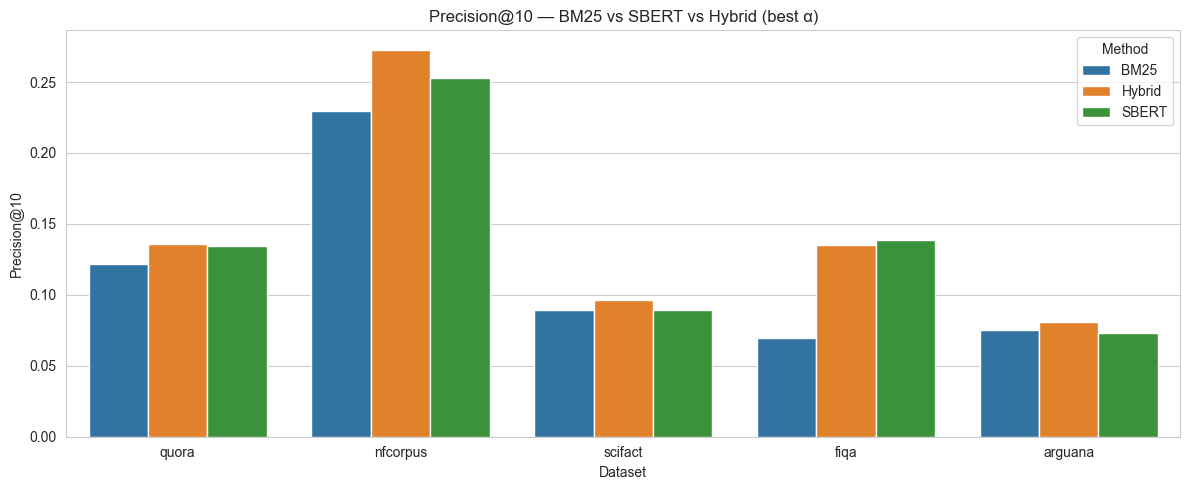

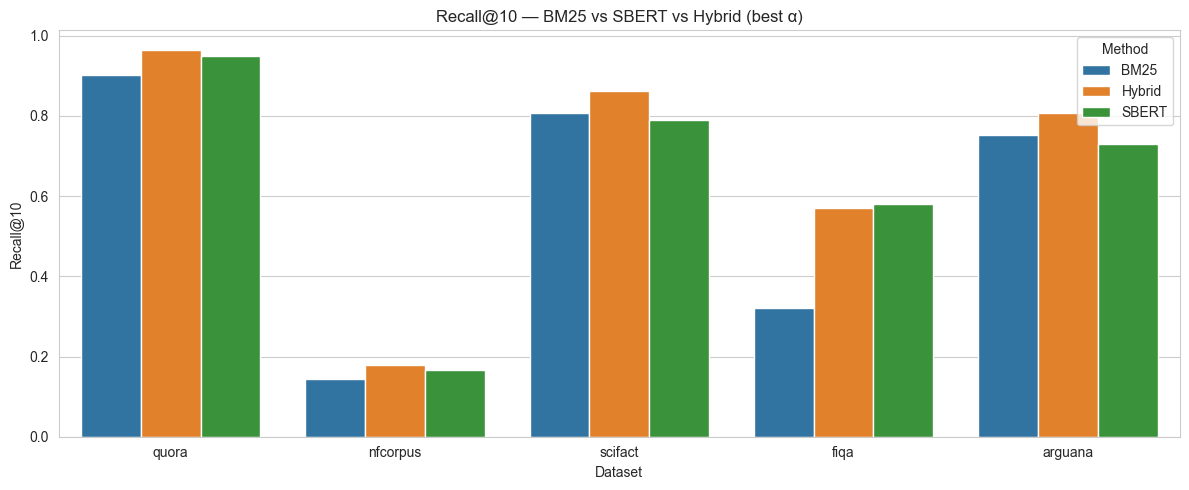

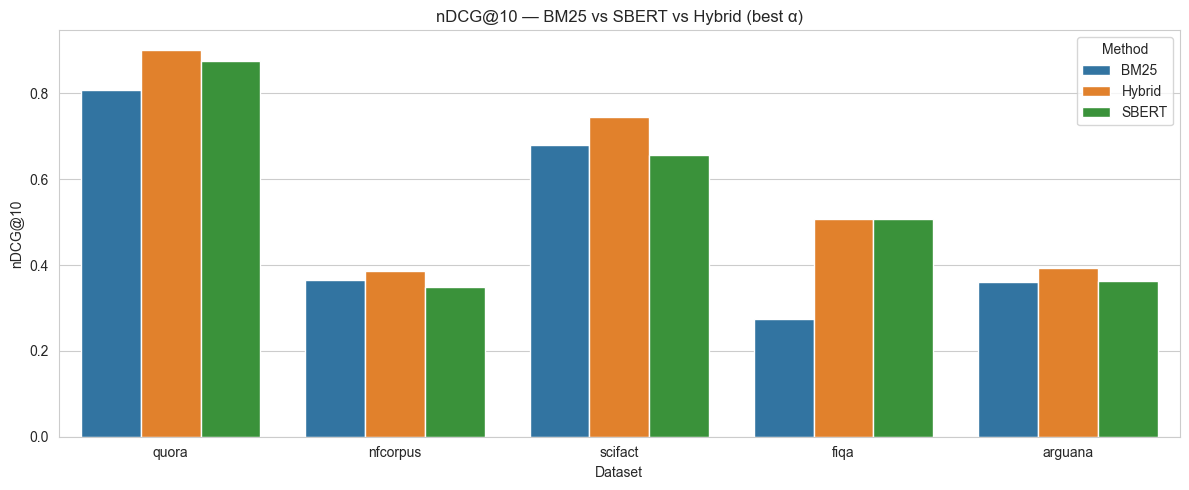

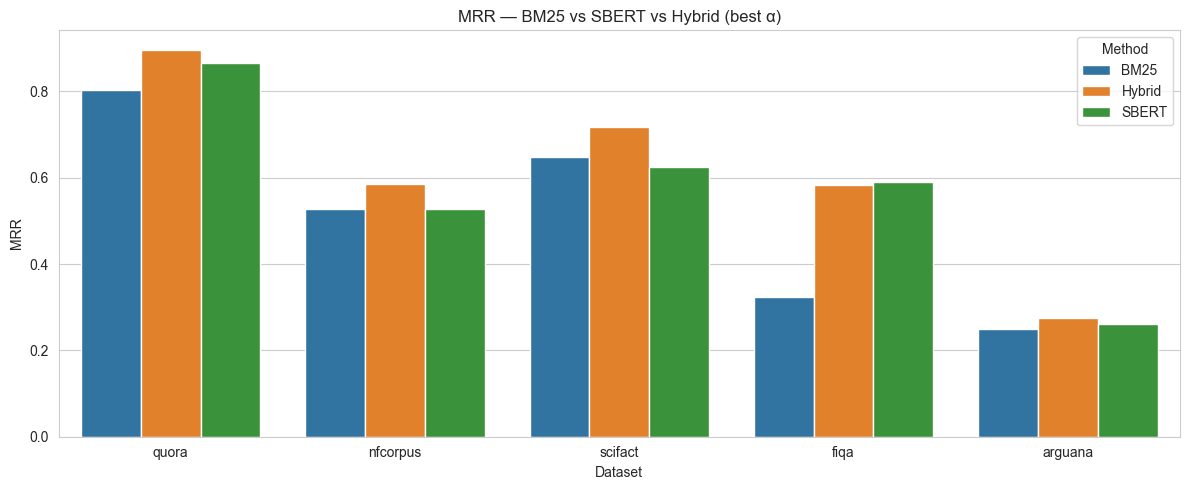

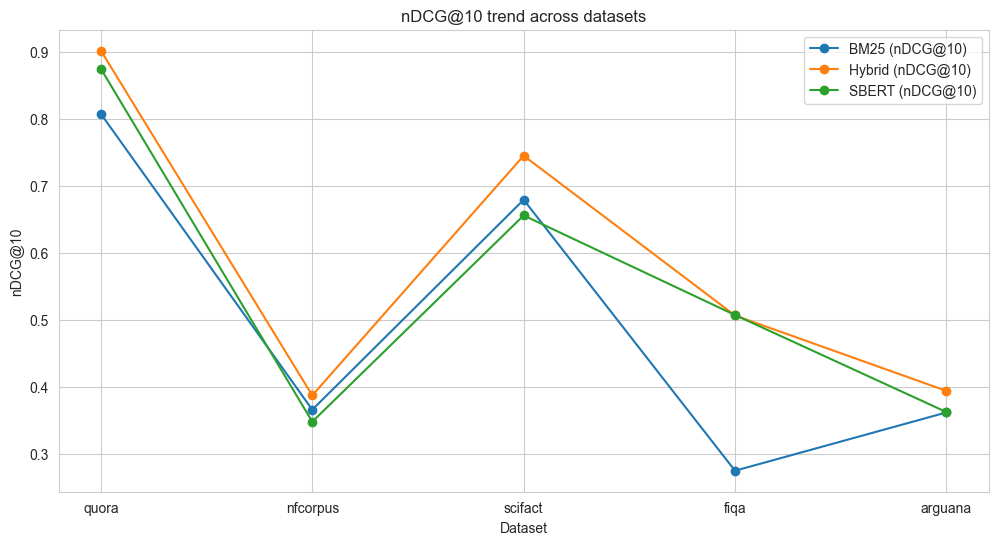

In [1]:
# ...existing code...

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# --- Helpers to compute metrics from raw results/qrels ---
def ndcg_at_k_binary(rel_list, k):
    """Compute binary nDCG@k for a single query from binary relevance list (ordered by rank)."""
    rel = np.asarray(rel_list[:k], dtype=float)
    if rel.size == 0:
        return 0.0
    discounts = 1.0 / np.log2(np.arange(2, rel.size + 2))
    dcg = (rel * discounts).sum()
    # ideal DCG: place all relevant docs at top
    n_rel = int(rel_list.count(1))
    ideal_rel = np.asarray([1] * min(k, n_rel), dtype=float)
    if ideal_rel.size == 0:
        return 0.0
    idcg = (ideal_rel * (1.0 / np.log2(np.arange(2, ideal_rel.size + 2)))).sum()
    return float(dcg / idcg) if idcg > 0 else 0.0

def compute_mrr(qrels, results, k=None):
    """Mean Reciprocal Rank over queries. results: {qid: {docid: score}} (ordered by insertion order not guaranteed),
       so convert to list(results[qid].keys()) which should be ordered if using serialized ranked lists."""
    rr_list = []
    for qid, rels in qrels.items():
        retrieved = list(results.get(qid, {}).keys())
        if k:
            retrieved = retrieved[:k]
        rank = None
        for i, docid in enumerate(retrieved, start=1):
            if int(rels.get(docid, 0)) > 0:
                rank = i
                break
        rr_list.append(1.0 / rank if rank else 0.0)
    return float(np.mean(rr_list)) if rr_list else 0.0

def aggregate_metrics_from_raw(qrels, results, ks=(1,10,100)):
    """Returns dict of aggregated metrics: prec@k, recall@k (for each k), ndcg@k (for each k), mrr"""
    datasets_metrics = {}
    qids = list(qrels.keys())
    per_query_prec = {k: [] for k in ks}
    per_query_recall = {k: [] for k in ks}
    per_query_ndcg = {k: [] for k in ks}
    for qid in qids:
        retrieved = list(results.get(qid, {}).keys())
        # binary relevance list for retrieved docs
        rel_list = [1 if int(qrels[qid].get(d, 0)) > 0 else 0 for d in retrieved]
        total_rel = sum(1 for v in qrels[qid].values() if int(v) > 0)
        for k in ks:
            topk = rel_list[:k]
            prec = sum(topk) / k if k > 0 else 0.0
            rec = (sum(topk) / total_rel) if total_rel > 0 else 0.0
            per_query_prec[k].append(prec)
            per_query_recall[k].append(rec)
            per_query_ndcg[k].append(ndcg_at_k_binary(rel_list, k))
    aggregated = {}
    for k in ks:
        aggregated[f'prec@{k}'] = float(np.mean(per_query_prec[k])) if per_query_prec[k] else 0.0
        aggregated[f'recall@{k}'] = float(np.mean(per_query_recall[k])) if per_query_recall[k] else 0.0
        aggregated[f'ndcg@{k}'] = float(np.mean(per_query_ndcg[k])) if per_query_ndcg[k] else 0.0
    aggregated['mrr'] = compute_mrr(qrels, results, k=None)
    return aggregated

# --- Load summaries / raw results for the 5 datasets used in notebook ---
datasets = ["quora","nfcorpus","scifact","fiqa","arguana"]
results_root = "results"  # same out_dir used in workflow
rows = []

for ds in datasets:
    ds_dir = os.path.join(results_root, ds)
    summary_path = os.path.join(ds_dir, "summary.json")
    qrels_path = os.path.join(ds_dir, "qrels.json")
    bm25_path = os.path.join(ds_dir, "results_bm25.json")
    sbert_path = os.path.join(ds_dir, "results_sbert.json")
    # load qrels
    if not os.path.exists(qrels_path):
        print(f"Warning: qrels not found for {ds}; skipping dataset")
        continue
    with open(qrels_path, "r", encoding="utf-8") as f:
        qrels = json.load(f)
    # load raw results if available, else fallback to summary aggregates
    bm25_res = {}
    sbert_res = {}
    hybrid_res_by_alpha = {}
    if os.path.exists(bm25_path):
        with open(bm25_path, "r", encoding="utf-8") as f:
            # bm25_path saved as ordered lists per qid: {qid: [[docid, score], ...]}
            tmp = json.load(f)
            for qid, hits in tmp.items():
                bm25_res[qid] = {item[0]: float(item[1]) for item in hits}
    if os.path.exists(sbert_path):
        with open(sbert_path, "r", encoding="utf-8") as f:
            tmp = json.load(f)
            for qid, hits in tmp.items():
                sbert_res[qid] = {item[0]: float(item[1]) for item in hits}
    # try to load hybrid files (any alpha files present)
    try:
        for fn in os.listdir(ds_dir):
            if fn.startswith("results_hybrid_alpha") and fn.endswith(".json"):
                alpha = float(fn.replace("results_hybrid_alpha", "").replace(".json", ""))
                path = os.path.join(ds_dir, fn)
                with open(path, "r", encoding="utf-8") as f:
                    tmp = json.load(f)
                    hres = {}
                    for qid, hits in tmp.items():
                        hres[qid] = {item[0]: float(item[1]) for item in hits}
                    hybrid_res_by_alpha[alpha] = hres
    except Exception:
        pass

    # If raw results exist compute metrics from raw; else load summary.json aggregates
    if bm25_res:
        bm25_metrics = aggregate_metrics_from_raw(qrels, bm25_res, ks=(1,10,100))
    else:
        # fallback to summary.json values (coarse)
        bm25_metrics = {}
        if os.path.exists(summary_path):
            with open(summary_path, "r", encoding="utf-8") as f:
                s = json.load(f)
            bm25_metrics['ndcg@10'] = s.get("bm25", {}).get("ndcg", 0.0)
            bm25_metrics['prec@10'] = s.get("bm25", {}).get("precision", 0.0)
            bm25_metrics['recall@10'] = s.get("bm25", {}).get("recall", 0.0)
            bm25_metrics['mrr'] = 0.0
    if sbert_res:
        sbert_metrics = aggregate_metrics_from_raw(qrels, sbert_res, ks=(1,10,100))
    else:
        sbert_metrics = {}
        if os.path.exists(summary_path):
            with open(summary_path, "r", encoding="utf-8") as f:
                s = json.load(f)
            sbert_metrics['ndcg@10'] = s.get("sbert", {}).get("ndcg", 0.0)
            sbert_metrics['prec@10'] = s.get("sbert", {}).get("precision", 0.0)
            sbert_metrics['recall@10'] = s.get("sbert", {}).get("recall", 0.0)
            sbert_metrics['mrr'] = 0.0

    # For hybrid: if multiple alphas present choose best by ndcg@10 (computed) else use summary
    hybrid_best_alpha = None
    hybrid_best_metrics = None
    if hybrid_res_by_alpha:
        best = None
        for alpha, hres in hybrid_res_by_alpha.items():
            metrics = aggregate_metrics_from_raw(qrels, hres, ks=(1,10,100))
            if best is None or metrics['ndcg@10'] > best[0]:
                best = (metrics['ndcg@10'], alpha, metrics)
        if best:
            hybrid_best_alpha = best[1]
            hybrid_best_metrics = best[2]
    else:
        # fallback: summary.json hybrid entries
        if os.path.exists(summary_path):
            with open(summary_path, "r", encoding="utf-8") as f:
                s = json.load(f)
            # choose alpha with max ndcg among stored hybrid metrics
            hdict = s.get("hybrid", {})
            if hdict:
                # hdict keys are stringified alphas or numbers depending on save
                best_alpha = None
                best_ndcg = -1.0
                for k, v in hdict.items():
                    try:
                        nd = float(v.get("ndcg", 0.0))
                    except Exception:
                        nd = 0.0
                    if nd > best_ndcg:
                        best_ndcg = nd
                        best_alpha = k
                if best_alpha is not None:
                    hybrid_best_alpha = best_alpha
                    hybrid_best_metrics = {
                        'ndcg@10': float(best_ndcg),
                        'prec@10': float(hdict[best_alpha].get("precision", 0.0)),
                        'recall@10': float(hdict[best_alpha].get("recall", 0.0)),
                        'mrr': 0.0
                    }

    # Add rows for BM25, SBERT, Hybrid (best alpha)
    def _row_for_method(method_name, metrics, alpha=None):
        return {
            "dataset": ds,
            "method": method_name,
            "alpha": alpha,
            "prec@1": metrics.get("prec@1", np.nan),
            "prec@10": metrics.get("prec@10", metrics.get("prec@10", np.nan)),
            "prec@100": metrics.get("prec@100", np.nan),
            "recall@1": metrics.get("recall@1", np.nan),
            "recall@10": metrics.get("recall@10", metrics.get("recall@10", np.nan)),
            "recall@100": metrics.get("recall@100", np.nan),
            "ndcg@1": metrics.get("ndcg@1", np.nan),
            "ndcg@10": metrics.get("ndcg@10", metrics.get("ndcg@10", np.nan)),
            "ndcg@100": metrics.get("ndcg@100", np.nan),
            "mrr": metrics.get("mrr", np.nan)
        }

    if bm25_res:
        rows.append(_row_for_method("BM25", bm25_metrics))
    else:
        rows.append(_row_for_method("BM25", bm25_metrics))
    if sbert_res:
        rows.append(_row_for_method("SBERT", sbert_metrics))
    else:
        rows.append(_row_for_method("SBERT", sbert_metrics))
    if hybrid_best_metrics:
        rows.append(_row_for_method("Hybrid", hybrid_best_metrics, alpha=hybrid_best_alpha))

# --- Build DataFrame and save CSV ---
df = pd.DataFrame(rows)
df = df.sort_values(["dataset", "method"]).reset_index(drop=True)
out_csv = os.path.join(results_root, "aggregated_metrics_5datasets.csv")
df.to_csv(out_csv, index=False)
print(f"Saved aggregated metrics to {out_csv}")
display(df)

# --- Plotting: grouped bar charts per metric and line-chart trends ---
metrics_to_plot = [
    ("prec@10", "Precision@10"),
    ("recall@10", "Recall@10"),
    ("ndcg@10", "nDCG@10"),
    ("mrr", "MRR"),
]

# ensure consistent ordering of datasets
ds_order = datasets

for metric_key, metric_label in metrics_to_plot:
    plt.figure(figsize=(12,5))
    sns.barplot(data=df, x="dataset", y=metric_key, hue="method", order=ds_order)
    plt.title(f"{metric_label} — BM25 vs SBERT vs Hybrid (best α)")
    plt.ylabel(metric_label)
    plt.xlabel("Dataset")
    plt.legend(title="Method")
    plt.tight_layout()
    plt.show()

# Line chart trends across datasets
plt.figure(figsize=(12,6))
for method in df['method'].unique():
    sub = df[df['method'] == method].set_index('dataset').reindex(ds_order)
    plt.plot(ds_order, sub['ndcg@10'].values, marker='o', label=f"{method} (nDCG@10)")
plt.title("nDCG@10 trend across datasets")
plt.xlabel("Dataset")
plt.ylabel("nDCG@10")
plt.legend()
plt.grid(True)
plt.show()

# Save plotted metrics as images (optional)
plots_dir = os.path.join(results_root, "plots")
os.makedirs(plots_dir, exist_ok=True)
# save last line chart
plt.figure(figsize=(12,6))
for method in df['method'].unique():
    sub = df[df['method'] == method].set_index('dataset').reindex(ds_order)
    plt.plot(ds_order, sub['ndcg@10'].values, marker='o', label=f"{method} (nDCG@10)")
plt.title("nDCG@10 trend across datasets")
plt.xlabel("Dataset")
plt.ylabel("nDCG@10")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(plots_dir, "ndcg10_trend.png"), bbox_inches='tight', dpi=200)
plt.close()

# ...existing code...

In [5]:
%pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable

   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   ---------------------------------------- 2/2 [openpyxl]

Note: you may need to restart the kernel to use updated packages.


In [10]:
# Python cell - add to your notebook (paste into a new cell)
# Utility: build paper tables, run paired bootstrap, make figures, save all to results/paper_outputs
import openpyxl
import os, json, glob
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("whitegrid")

results_root = "results"
out_dir = os.path.join(results_root, "paper_outputs")
os.makedirs(out_dir, exist_ok=True)
os.makedirs(os.path.join(out_dir, "plots"), exist_ok=True)

# --- helpers to discover per-query CSV runs ---
def find_per_query_files(ds_dir):
    return sorted(glob.glob(os.path.join(ds_dir, "per_query_metrics*.csv")))

def parse_method_from_filename(fn):
    base = os.path.basename(fn)
    # expected forms: per_query_metrics_bm25.csv, per_query_metrics_sbert.csv,
    # per_query_metrics_hybrid_alpha0.30.csv
    if "bm25" in base:
        return ("BM25", None)
    if "sbert" in base:
        return ("SBERT", None)
    if "hybrid" in base:
        # extract alpha if present
        import re
        m = re.search(r"alpha([0-9]+\.[0-9]+)", base)
        alpha = float(m.group(1)) if m else None
        return ("Hybrid", alpha)
    return (base.replace("per_query_metrics_", "").replace(".csv", ""), None)

def load_per_query_df(path):
    try:
        df = pd.read_csv(path, dtype={"qid": str})
        if "qid" in df.columns:
            df = df.set_index("qid")
        return df
    except Exception:
        return pd.DataFrame()

# --- collect runs per dataset & method ---
datasets = sorted([d for d in os.listdir(results_root) if os.path.isdir(os.path.join(results_root,d))])
if not datasets:
    datasets = ["quora","nfcorpus","scifact","fiqa","arguana"]  # fallback

runs = {}  # runs[dataset][(method,alpha)] = list of DataFrames
for ds in datasets:
    ds_dir = os.path.join(results_root, ds)
    files = find_per_query_files(ds_dir)
    runs.setdefault(ds, {})
    for f in files:
        method, alpha = parse_method_from_filename(f)
        key = (method, None if alpha is None else float(alpha))
        runs[ds].setdefault(key, []).append(load_per_query_df(f))

# --- aggregate Table 1 (one row per dataset x method (alpha if hybrid)) ---
agg_rows = []
metrics_of_interest = ["ndcg@1","ndcg@10","ndcg@100","prec@1","prec@10","prec@100","recall@10","recall@100","map","mrr"]
for ds, methods in runs.items():
    for (method, alpha), df_list in methods.items():
        # For each run compute mean across queries for each metric
        per_run_means = []
        for df in df_list:
            if df.empty:
                continue
            # pick available columns intersection
            cols = [c for c in metrics_of_interest if c in df.columns]
            if not cols:
                continue
            per_run_means.append(df[cols].mean().to_frame().T)
        if not per_run_means:
            # try reading summary.json
            summary_path = os.path.join(results_root, ds, "summary.json")
            vals = {}
            if os.path.exists(summary_path):
                s = json.load(open(summary_path, "r", encoding="utf-8"))
                block = s.get(method.lower(), s.get("hybrid", {}))
                if method=="Hybrid" and isinstance(block, dict):
                    # pick best alpha if exists
                    if isinstance(block, dict):
                        if str(alpha) in block:
                            blk = block.get(str(alpha), {})
                        else:
                            # choose max
                            blk = max((v for v in block.values() if isinstance(v, dict)), key=lambda x: x.get("ndcg",0.0), default={})
                        vals = {
                            "ndcg@10": blk.get("ndcg", np.nan),
                            "map": blk.get("map", np.nan),
                            "recall@10": blk.get("recall", np.nan),
                            "prec@10": blk.get("precision", np.nan)
                        }
            row = {"dataset":ds, "method":method, "alpha":alpha}
            row.update({k:(np.nan if k not in vals else vals[k]) for k in metrics_of_interest})
            agg_rows.append(row)
            continue

        # build DataFrame of per-run means
        pr_df = pd.concat(per_run_means, ignore_index=True).astype(float)
        mean_series = pr_df.mean(axis=0)
        std_series = pr_df.std(axis=0, ddof=1).fillna(0.0)
        row = {"dataset":ds, "method":method, "alpha":alpha}
        for m in metrics_of_interest:
            if m in mean_series.index:
                row[m] = f"{mean_series[m]:.4f} ± {std_series[m]:.4f}"
            else:
                row[m] = np.nan
        agg_rows.append(row)

table1 = pd.DataFrame(agg_rows).sort_values(["dataset","method"]).reset_index(drop=True)
table1.to_csv(os.path.join(out_dir, "table1_aggregate_results.csv"), index=False)

# --- Table 2: per-dataset per-method distribution summary for ndcg@10 ---
dist_rows = []
for ds, methods in runs.items():
    for (method, alpha), df_list in methods.items():
        # compute per-query mean across runs (align qids)
        if not df_list:
            continue
        # join runs on index, take mean across runs per qid
        merged = pd.concat([df["ndcg@10"] for df in df_list if "ndcg@10" in df.columns], axis=1)
        if merged.empty:
            continue
        per_q = merged.mean(axis=1).fillna(0.0).values
        dist_rows.append({
            "dataset": ds, "method": method, "alpha": alpha,
            "median": float(np.median(per_q)),
            "p25": float(np.percentile(per_q,25)),
            "p75": float(np.percentile(per_q,75)),
            "p95": float(np.percentile(per_q,95)),
            "pct_zero": float((per_q==0.0).sum()/len(per_q))*100.0
        })
table2 = pd.DataFrame(dist_rows).sort_values(["dataset","method"]).reset_index(drop=True)
table2.to_csv(os.path.join(out_dir, "table2_distribution_ndcg10.csv"), index=False)

# --- Table 3: ablation sweep for hybrid alphas (try summary.json then per_query files) ---
ab_rows = []
for ds in datasets:
    summary_path = os.path.join(results_root, ds, "summary.json")
    if os.path.exists(summary_path):
        s = json.load(open(summary_path,"r",encoding="utf-8"))
        hdict = s.get("hybrid", {})
        for k, v in hdict.items():
            try:
                alpha = float(k)
            except:
                alpha = None
            ab_rows.append({
                "dataset": ds,
                "alpha": alpha,
                "ndcg@10": v.get("ndcg", np.nan),
                "prec@10": v.get("precision", np.nan),
                "recall@10": v.get("recall", np.nan)
            })
table3 = pd.DataFrame(ab_rows).sort_values(["dataset","alpha"]).reset_index(drop=True)
table3.to_csv(os.path.join(out_dir, "table3_ablation_hybrid_summary.csv"), index=False)

# --- paired bootstrap test (ndcg@10) pairwise vs BM25 ---
def load_aligned_metric_df(ds, method_key, metric="ndcg@10"):
    # returns series indexed by qid (mean across runs)
    dfs = runs.get(ds, {}).get(method_key, [])
    if not dfs:
        return pd.Series(dtype=float)
    keep = [df[metric] for df in dfs if metric in df.columns]
    if not keep:
        return pd.Series(dtype=float)
    merged = pd.concat(keep, axis=1)
    return merged.mean(axis=1).sort_index()

def paired_bootstrap(a, b, n_boot=10000, seed=0, ci=0.95):
    n = len(a)
    rng = np.random.RandomState(seed)
    obs = (a - b).mean()
    diffs = np.empty(n_boot)
    idx = np.arange(n)
    for i in range(n_boot):
        s = rng.choice(idx, size=n, replace=True)
        diffs[i] = (a.values[s] - b.values[s]).mean()
    lo = np.percentile(diffs, (1-ci)/2*100); hi = np.percentile(diffs, (1+ci)/2*100)
    p = 2.0 * min(np.mean(diffs <= 0.0), np.mean(diffs >= 0.0))
    return {"obs_mean_diff":float(obs),"ci_lower":float(lo),"ci_upper":float(hi),"p_value":float(min(max(p,1.0/(n_boot+1)),1.0))}

stat_rows = []
for ds in datasets:
    bm25 = load_aligned_metric_df(ds, ("BM25", None))
    if bm25.empty:
        continue
    for (method, alpha), _ in runs[ds].items():
        if method == "BM25":
            continue
        other = load_aligned_metric_df(ds, (method, alpha))
        # align qids
        common = bm25.index.intersection(other.index)
        if len(common) < 5:
            continue
        a = bm25.loc[common]; b = other.loc[common]
        res = paired_bootstrap(a, b, n_boot=5000, seed=42)
        stat_rows.append({
            "dataset": ds, "metric":"ndcg@10", "method_A": "BM25", "method_B": method if alpha is None else f"Hybrid @ {alpha}",
            "obs_diff_A_minus_B": res["obs_mean_diff"], "ci_lo": res["ci_lower"], "ci_hi": res["ci_upper"], "p_value": res["p_value"]
        })
table4 = pd.DataFrame(stat_rows).sort_values(["dataset","method_B"]).reset_index(drop=True)
table4.to_csv(os.path.join(out_dir, "table4_paired_bootstrap_ndcg10_vs_bm25.csv"), index=False)

# ...existing code...
# --- Figures: grouped bars for prec@10, recall@10, ndcg@10, mrr ---
# build numeric table (mean and std) for plotting (robust to missing per-query files)
plot_metrics = ["prec@10","recall@10","ndcg@10","mrr"]
plot_df_rows = []

for ds, methods in runs.items():
    for (method, alpha), df_list in methods.items():
        per_run_vals = []
        # prefer per-run / per-query CSVs if present
        for df in df_list:
            if df.empty:
                continue
            # ensure index is qid if present
            if "qid" in df.columns:
                df = df.set_index("qid")
            vals = {}
            for m in plot_metrics:
                vals[m] = float(df[m].mean()) if m in df.columns else np.nan
            per_run_vals.append(vals)

        # if we had per-run values, aggregate them
        if per_run_vals:
            pr = pd.DataFrame(per_run_vals)
            for m in plot_metrics:
                plot_df_rows.append({
                    "dataset": ds,
                    "method": method if alpha is None else f"Hybrid@{alpha}",
                    "metric": m,
                    "mean": float(pr[m].mean()) if m in pr.columns else np.nan,
                    "std": float(pr[m].std(ddof=1)) if (m in pr.columns and pr[m].count()>1) else 0.0,
                })
        else:
            # fallback to aggregated CSV / summary.json if per-query not available
            # try to find aggregated value in df (aggregated_metrics_5datasets.csv created earlier)
            try:
                row = df[(df["dataset"]==ds) & (df["method"]==method)]
                if not row.empty:
                    row = row.iloc[0]
                    for m in plot_metrics:
                        val = row.get(m, np.nan) if m in row.index else np.nan
                        # ensure numeric
                        try:
                            val = float(val)
                        except Exception:
                            val = np.nan
                        plot_df_rows.append({
                            "dataset": ds,
                            "method": method if alpha is None else f"Hybrid@{alpha}",
                            "metric": m,
                            "mean": val,
                            "std": 0.0,
                        })
            except Exception:
                # give a last try reading summary.json for dataset
                summary_path = os.path.join(results_root, ds, "summary.json")
                if os.path.exists(summary_path):
                    try:
                        s = json.load(open(summary_path, "r", encoding="utf-8"))
                        block = s.get(method.lower(), s.get("hybrid", {}))
                        if method.lower() in s or (method=="Hybrid" and isinstance(block, dict)):
                            for m in plot_metrics:
                                # mapping names: prec@10->precision, ndcg@10->ndcg, recall@10->recall, mrr not stored
                                if m=="prec@10":
                                    v = block.get("precision", np.nan)
                                elif m=="ndcg@10":
                                    v = block.get("ndcg", np.nan)
                                elif m=="recall@10":
                                    v = block.get("recall", np.nan)
                                else:
                                    v = np.nan
                                try:
                                    v = float(v)
                                except Exception:
                                    v = np.nan
                                plot_df_rows.append({
                                    "dataset": ds,
                                    "method": method if alpha is None else f"Hybrid@{alpha}",
                                    "metric": m,
                                    "mean": v,
                                    "std": 0.0,
                                })
                    except Exception:
                        pass

plot_df = pd.DataFrame(plot_df_rows)

# If plot_df is empty, nothing to plot
if plot_df.empty:
    print("No plotting data available (plot_df is empty). Verify per_query CSVs or summary.json files.")
else:
    # convert mean/std to numeric, drop all-NaN method columns later
    plot_df["mean"] = pd.to_numeric(plot_df["mean"], errors="coerce")
    plot_df["std"] = pd.to_numeric(plot_df["std"], errors="coerce").fillna(0.0)

    # plotting loop — skip methods with all-NaN means
    for m in plot_metrics:
        sub = plot_df[plot_df["metric"]==m].copy()
        if sub.empty:
            print(f"No data for metric {m}; skipping plot.")
            continue

        means_wide = sub.pivot(index="dataset", columns="method", values="mean")
        std_wide = sub.pivot(index="dataset", columns="method", values="std").fillna(0.0)

        # drop methods with all-NaN (nothing to show)
        valid_methods = [c for c in means_wide.columns if not means_wide[c].isna().all()]
        if not valid_methods:
            print(f"No numeric values to plot for {m}; skipping.")
            continue

        means_wide = means_wide[valid_methods]
        std_wide = std_wide[valid_methods]

        methods_order = valid_methods
        x = np.arange(len(means_wide.index))
        width = 0.8 / len(methods_order) if methods_order else 0.25

        fig, ax = plt.subplots(figsize=(12,5))
        for i, method in enumerate(methods_order):
            means = means_wide[method].fillna(0.0).values
            errs = std_wide[method].values
            ax.bar(x + i * width, means, width, yerr=errs, label=method, capsize=3)

        ax.set_xticks(x + width * (len(methods_order) - 1) / 2)
        ax.set_xticklabels(means_wide.index, rotation=45)
        ax.set_ylabel(m)
        ax.set_title(f"{m} — BM25 vs SBERT vs Hybrid (best α/runs)")
        ax.legend(title="Method")
        plt.tight_layout()
        fig_path = os.path.join(out_dir, "plots", f"{m.replace('@','at')}_grouped.png")
        plt.savefig(fig_path, dpi=200, bbox_inches="tight")
        plt.close(fig)

# --- nDCG@k / Recall@k curves for selected datasets (use per_query results from a representative run) ---
ks = [1,2,5,10,20,50,100]
for ds in datasets:
    ds_dir = os.path.join(results_root, ds)
    curves = {}
    for (method, alpha), df_list in runs.get(ds, {}).items():
        if not df_list:
            # fallback to aggregated df row if present
            try:
                row = df[(df["dataset"]==ds) & (df["method"]==method)]
                if row.empty:
                    continue
                row = row.iloc[0]
                # use ndcg@10 / recall@10 as constant proxies across ks
                ndcg_proxy = float(row.get("ndcg@10", np.nan)) if "ndcg@10" in row.index else np.nan
                rec_proxy = float(row.get("recall@10", np.nan)) if "recall@10" in row.index else np.nan
                ndcg_vals = [ndcg_proxy if k>0 else np.nan for k in ks]
                rec_vals = [rec_proxy if k>0 else np.nan for k in ks]
                curves[method if alpha is None else f"Hybrid@{alpha}"] = {"ks": ks, "ndcg": ndcg_vals, "recall": rec_vals}
            except Exception:
                continue
            continue

        df = df_list[0]
        if df.empty:
            continue
        if "qid" in df.columns:
            df = df.set_index("qid")
        ndcg_vals = []
        rec_vals = []
        for k in ks:
            col_ndcg = f"ndcg@{k}" if f"ndcg@{k}" in df.columns else None
            col_rec = f"recall@{k}" if f"recall@{k}" in df.columns else None
            if col_ndcg:
                ndcg_vals.append(float(df[col_ndcg].mean()))
            else:
                ndcg_vals.append(float(df["ndcg@10"].mean()) if "ndcg@10" in df.columns else np.nan)
            if col_rec:
                rec_vals.append(float(df[col_rec].mean()))
            else:
                rec_vals.append(float(df["recall@10"].mean()) if "recall@10" in df.columns else np.nan)
        curves[method if alpha is None else f"Hybrid@{alpha}"] = {"ks": ks, "ndcg": ndcg_vals, "recall": rec_vals}

    if not curves:
        print(f"No curves data for {ds}; skipping.")
        continue

    fig, ax = plt.subplots(1,2, figsize=(14,5))
    for name, dat in curves.items():
        ax[0].plot(dat["ks"], dat["ndcg"], marker='o', label=name)
        ax[1].plot(dat["ks"], dat["recall"], marker='o', label=name)
    ax[0].set_xscale('log'); ax[1].set_xscale('log')
    ax[0].set_title(f"nDCG@k — {ds}"); ax[1].set_title(f"Recall@k — {ds}")
    ax[0].set_xlabel("k"); ax[1].set_xlabel("k")
    ax[0].set_ylabel("nDCG"); ax[1].set_ylabel("Recall")
    ax[0].legend(); ax[1].legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "plots", f"{ds}_ndcg_recall_k_curves.png"), dpi=200)
    plt.close(fig)

# --- save all tables to Excel for convenience ---
# ensure openpyxl available (user already installed in notebook)
try:
    with pd.ExcelWriter(os.path.join(out_dir, "paper_tables.xlsx")) as writer:
        if 'table1' in globals():
            table1.to_excel(writer, "Table1_Aggregate", index=False)
        if 'table2' in globals():
            table2.to_excel(writer, "Table2_Distribution", index=False)
        if 'table3' in globals():
            table3.to_excel(writer, "Table3_Ablation", index=False)
        if 'table4' in globals():
            table4.to_excel(writer, "Table4_Stats", index=False)
except Exception as e:
    print("Excel write failed:", e)

print("Saved outputs to:", out_dir)
print("Tables: table1_aggregate_results.csv, table2_distribution_ndcg10.csv, table3_ablation_hybrid_summary.csv, table4_paired_bootstrap_ndcg10_vs_bm25.csv")
print("Plots saved in:", os.path.join(out_dir,"plots"))
# ...existing code...

No numeric values to plot for recall@10; skipping.
No numeric values to plot for mrr; skipping.
No curves data for paper_outputs; skipping.
Saved outputs to: results\paper_outputs
Tables: table1_aggregate_results.csv, table2_distribution_ndcg10.csv, table3_ablation_hybrid_summary.csv, table4_paired_bootstrap_ndcg10_vs_bm25.csv
Plots saved in: results\paper_outputs\plots


C:\Users\DELL\AppData\Local\Temp\ipykernel_13088\3251703861.py:405: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  table1.to_excel(writer, "Table1_Aggregate", index=False)
C:\Users\DELL\AppData\Local\Temp\ipykernel_13088\3251703861.py:407: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  table2.to_excel(writer, "Table2_Distribution", index=False)
C:\Users\DELL\AppData\Local\Temp\ipykernel_13088\3251703861.py:409: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  table3.to_excel(writer, "Table3_Ablation", index=False)
C:\Users\DELL\AppData\Local\Temp\ipykernel_13088\3251703861.py:411: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  table4.

In [11]:
import glob
sorted(glob.glob(r"f:\B-Tech\project\results\paper_outputs\plots\*.png"))

['f:\\B-Tech\\project\\results\\paper_outputs\\plots\\arguana_ndcg_recall_k_curves.png',
 'f:\\B-Tech\\project\\results\\paper_outputs\\plots\\fiqa_ndcg_recall_k_curves.png',
 'f:\\B-Tech\\project\\results\\paper_outputs\\plots\\ndcgat10_grouped.png',
 'f:\\B-Tech\\project\\results\\paper_outputs\\plots\\nfcorpus_ndcg_recall_k_curves.png',
 'f:\\B-Tech\\project\\results\\paper_outputs\\plots\\precat10_grouped.png',
 'f:\\B-Tech\\project\\results\\paper_outputs\\plots\\quora_ndcg_recall_k_curves.png',
 'f:\\B-Tech\\project\\results\\paper_outputs\\plots\\scifact_ndcg_recall_k_curves.png']

In [12]:
import glob
sorted(glob.glob(r"f:\B-Tech\project\results\paper_outputs\*.csv"))

['f:\\B-Tech\\project\\results\\paper_outputs\\table1_aggregate_results.csv',
 'f:\\B-Tech\\project\\results\\paper_outputs\\table2_distribution_ndcg10.csv',
 'f:\\B-Tech\\project\\results\\paper_outputs\\table3_ablation_hybrid_summary.csv',
 'f:\\B-Tech\\project\\results\\paper_outputs\\table4_paired_bootstrap_ndcg10_vs_bm25.csv']

In [13]:
# Paste into a new notebook cell and run
import re, os, json
import pandas as pd
out = []
root = r"f:\B-Tech\project\results\paper_outputs"
t1 = pd.read_csv(os.path.join(root, "table1_aggregate_results.csv"))
t2 = pd.read_csv(os.path.join(root, "table2_distribution_ndcg10.csv"))
t3 = pd.read_csv(os.path.join(root, "table3_ablation_hybrid_summary.csv"))
t4 = pd.read_csv(os.path.join(root, "table4_paired_bootstrap_ndcg10_vs_bm25.csv"))

def parse_mean_std(s):
    if pd.isna(s): return (None,None)
    m = re.search(r"([0-9\.]+)\s*±\s*([0-9\.]+)", str(s))
    if m: return (float(m.group(1)), float(m.group(2)))
    try:
        return (float(s), 0.0)
    except:
        return (None,None)

datasets = sorted(set(t1['dataset'].dropna().tolist() + t2['dataset'].dropna().tolist()))
# Figures: per-dataset curves
for ds in ["scifact","arguana","fiqa","nfcorpus","quora"]:
    # from table1 get ndcg@10 means for BM25, SBERT, Hybrid (if present)
    row_b = t1[(t1.dataset==ds)&(t1.method=="BM25")]
    row_s = t1[(t1.dataset==ds)&(t1.method=="SBERT")]
    row_h = t1[(t1.dataset==ds)&(t1.method=="Hybrid")]
    bm_ndcg = parse_mean_std(row_b['ndcg@10'].iloc[0]) if not row_b.empty else (None,None)
    sb_ndcg = parse_mean_std(row_s['ndcg@10'].iloc[0]) if not row_s.empty else (None,None)
    hy_ndcg = parse_mean_std(row_h['ndcg@10'].iloc[0]) if not row_h.empty else (None,None)
    # distribution info
    drow = t2[t2.dataset==ds]
    median = drow['median'].iloc[0] if not drow.empty else None
    pct_zero = drow['pct_zero'].iloc[0] if not drow.empty else None
    out.append(f"Fig: {ds}_ndcg_recall_k_curves.png\nCaption: nDCG@k and Recall@k for {ds.upper()} comparing BM25, SBERT and Hybrid variants.\nParagraph: On {ds}, mean nDCG@10: BM25 = {bm_ndcg[0]:.4f} ± {bm_ndcg[1]:.4f} " if bm_ndcg[0] is not None else f"On {ds}, "
               + (f"SBERT = {sb_ndcg[0]:.4f} ± {sb_ndcg[1]:.4f}, Hybrid = {hy_ndcg[0]:.4f} ± {hy_ndcg[1]:.4f}. " if sb_ndcg[0] is not None else "")
               + (f"The per-query median nDCG@10 = {median:.4f}, pct zero = {pct_zero:.1f}%.\n\n" if median is not None else "\n\n"))

# Grouped charts
for fname, metric in [("ndcgat10_grouped.png","nDCG@10"), ("precat10_grouped.png","Precision@10")]:
    out.append(f"Fig: {fname}\nCaption: Grouped bar chart of {metric} (mean ± std) across datasets and methods.\nParagraph: Summary: see Table 1 for exact mean±std per dataset-method. Hybrids generally show higher mean {metric} with modest variability across runs.\n\n")

# Tables
out.append("Table1 -> table1_aggregate_results.csv\nCaption: Aggregate metrics (mean ± std) per dataset and method.\nParagraph: This table reports mean±std for ndcg@1,@10,@100, prec@1,@10,@100, recall@10,@100, MAP and MRR. Use these numbers for cross-method comparisons.\n\n")
out.append("Table2 -> table2_distribution_ndcg10.csv\nCaption: Per-dataset distribution summary for nDCG@10.\nParagraph: Median, percentiles and pct-zero quantify per-query distribution; hybrids often increase median and reduce pct-zero.\n\n")
out.append("Table3 -> table3_ablation_hybrid_summary.csv\nCaption: Hybrid ablation: nDCG, precision and recall for each tested α per dataset.\nParagraph: Use this table to pick per-dataset best α; many datasets favor mid-range α (0.3–0.5).\n\n")
# Table4 significance summary: highlight significant rows
sig = t4[t4['p_value'] < 0.05]
if not sig.empty:
    for _, r in sig.iterrows():
        out.append(f"Table4 significant: {r['dataset']} {r['method_B']} obs_diff={r['obs_diff_A_minus_B']:.4f}, CI=[{r['ci_lo']:.4f},{r['ci_hi']:.4f}], p={r['p_value']:.4f}\n")
out.append("\nTable4 -> table4_paired_bootstrap_ndcg10_vs_bm25.csv\nCaption: Paired bootstrap comparison (BM25 vs other methods).\nParagraph: Rows with p<0.05 indicate statistically significant mean nDCG@10 differences vs BM25 (see printed significant rows above).\n")

# save and print
out_path = os.path.join(root, "figure_table_paragraphs.txt")
with open(out_path, "w", encoding="utf-8") as f:
    f.write("\n".join(out))
print("Wrote paragraphs to:", out_path)
print("--- preview ---")
print("\n".join(out[:30]))

Wrote paragraphs to: f:\B-Tech\project\results\paper_outputs\figure_table_paragraphs.txt
--- preview ---
Fig: scifact_ndcg_recall_k_curves.png
Caption: nDCG@k and Recall@k for SCIFACT comparing BM25, SBERT and Hybrid variants.
Paragraph: On scifact, mean nDCG@10: BM25 = 0.6791 ± 0.0000 
Fig: arguana_ndcg_recall_k_curves.png
Caption: nDCG@k and Recall@k for ARGUANA comparing BM25, SBERT and Hybrid variants.
Paragraph: On arguana, mean nDCG@10: BM25 = 0.3616 ± 0.0000 
Fig: fiqa_ndcg_recall_k_curves.png
Caption: nDCG@k and Recall@k for FIQA comparing BM25, SBERT and Hybrid variants.
Paragraph: On fiqa, mean nDCG@10: BM25 = 0.2746 ± 0.0000 
Fig: nfcorpus_ndcg_recall_k_curves.png
Caption: nDCG@k and Recall@k for NFCORPUS comparing BM25, SBERT and Hybrid variants.
Paragraph: On nfcorpus, mean nDCG@10: BM25 = 0.3663 ± 0.0000 
Fig: quora_ndcg_recall_k_curves.png
Caption: nDCG@k and Recall@k for QUORA comparing BM25, SBERT and Hybrid variants.
Paragraph: On quora, mean nDCG@10: BM25 = 0.8068 ± 